In [121]:
import pandas as pd
import numpy as np
import torch
import torch.nn.functional as F
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from torch_geometric.data import Data
from torch_geometric.utils import from_networkx
import networkx as nx
from torch_geometric.nn import GCNConv
from torch_geometric.loader import DataLoader
import matplotlib.pyplot as plt

In [122]:
df = pd.read_csv('../data/cleaned/cleaned_vessel_calls.csv')

In [123]:
# Preprocess the dataframe
df["arrivalDate"] = pd.to_datetime(df["arrivalDate"])
df["sailingDate"] = pd.to_datetime(df["sailingDate"])
df["duration"] = (df["sailingDate"] - df["arrivalDate"]) / pd.Timedelta(days=1)
df["month"] = df["arrivalDate"].dt.month
df.dropna(inplace=True)

In [124]:
# Sort and filter data
df.sort_values(by=["IMO", "arrivalDate"], inplace=True)
df['next_unlocode'] = df.groupby('IMO')['place.unlocode'].shift(-1)
df['is_last_imo'] = df['IMO'] != df['IMO'].shift(-1)
df = df[~df["is_last_imo"]]
df = df[df["Event_Type"] != "ARRIVAL"]

In [125]:
# Drop unnecessary columns
df = df.drop(columns=["is_last_imo", "Event_Type", "Timestamp", "vessel.vesselName", "IMO", "arrivalDate", "sailingDate"])

# Rename columns for consistency
df = df.rename(columns={'place.unlocode': 'current_unlocode', 'place.placeName': 'port_name', 'vessel.vesselType': 'vessel_type', 'place.placeType': 'place_type', 'place.countryName': 'country_name'})

In [126]:
df

,port_name,current_unlocode,place_type,country_name,vessel_type,duration,month,next_unlocode
314761,Los Angeles,USLAX,Port,United States of America,Vessel Type (unspecified),7.579803,1,CNJGY
314763,Jiangyin,CNJGY,Port,People's Republic of China,Vessel Type (unspecified),1.484931,2,CNTXG
314765,Tianjin Xingang Port,CNTXG,Port,People's Republic of China,Vessel Type (unspecified),0.854514,3,CNQAW
314767,Qianwan,CNQAW,Sub Port,People's Republic of China,Vessel Type (unspecified),0.613380,3,CNMSN
314769,Meishan,CNMSN,Sub Port,People's Republic of China,Vessel Type (unspecified),1.021157,3,CNNSA
...,...,...,...,...,...,...,...,...
12569,Port Klang (Pelabuhan Klang),MYPKG,Port,Malaysia,fully cellular containership,0.871701,9,INMAA
12571,Chennai (ex Madras),INMAA,Port,India,fully cellular containership,1.138021,9,BDCGP
12573,Chittagong (Chattogram),BDCGP,Port,Bangladesh,fully cellular containership,1.997604,9,THLCH
12575,Laem Chabang,THLCH,Port,Thailand,fully cellular containership,0.713912,9,SGSIN


In [127]:
# Encode categorical features
label_encoders = {}
for column in ['port_name', 'place_type', 'country_name', 'vessel_type']:
    le = LabelEncoder()
    df[column] = le.fit_transform(df[column].astype(str))
    label_encoders[column] = le

In [128]:
all_ports = pd.concat([df['current_unlocode'], df['next_unlocode']])

# Create unique identifiers for each port
unique_ports = all_ports.unique()
port_to_id = {port: i for i, port in enumerate(unique_ports)}

df['current_unlocode'] = df['current_unlocode'].map(port_to_id)
df['next_unlocode'] = df['next_unlocode'].map(port_to_id)

In [129]:
# Create the graph
G = nx.from_pandas_edgelist(df, 'current_unlocode', 'next_unlocode', edge_attr=True)

# Initialize all nodes with default attributes
default_attrs = {
    'port_name': 0,
    'place_type': 0,
    'country_name': 0,
    'vessel_type': 0,
    'duration': 0.0,
    'month': 0
}

for node in G.nodes:
    G.nodes[node].update(default_attrs)

# Add node features (example: duration and month)
for index, row in df.iterrows():
    G.nodes[row['current_unlocode']]['port_name'] = row['port_name']
    G.nodes[row['current_unlocode']]['place_type'] = row['place_type']
    G.nodes[row['current_unlocode']]['country_name'] = row['country_name']
    G.nodes[row['current_unlocode']]['vessel_type'] = row['vessel_type']
    G.nodes[row['current_unlocode']]['duration'] = row['duration']
    G.nodes[row['current_unlocode']]['month'] = row['month']

In [130]:
node_attrs = []
for node in G.nodes(data=True):
    node_attrs.append([node[1][attr] for attr in default_attrs.keys()])

node_attrs = np.array(node_attrs, dtype=np.float32)
scaler = MinMaxScaler()
node_attrs = scaler.fit_transform(node_attrs)

# Update graph with normalized attributes
for i, node in enumerate(G.nodes):
    for j, attr in enumerate(default_attrs.keys()):
        G.nodes[node][attr] = node_attrs[i, j]

# Convert to PyTorch Geometric data
data = from_networkx(G)

# Ensure features are tensors
data.x = torch.tensor([list(node[1].values()) for node in G.nodes(data=True)], dtype=torch.float)

# Set target variable y
node_to_index = {node: i for i, node in enumerate(G.nodes)}
data.y = torch.zeros(len(G.nodes), dtype=torch.long)
for index, row in df.iterrows():
    node_index = node_to_index[row['current_unlocode']]
    data.y[node_index] = row['next_unlocode']

# Ensure the target values are within the valid range
num_classes = len(np.unique(data.y.numpy()))
data.y = torch.clamp(data.y, max=num_classes-1)

In [131]:
class GNN(torch.nn.Module):
    def __init__(self, num_node_features, num_classes):
        super(GNN, self).__init__()
        self.conv1 = GCNConv(num_node_features, 16)
        self.conv2 = GCNConv(16, num_classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

num_node_features = data.x.shape[1]
model = GNN(num_node_features, num_classes)

In [132]:
# Split the data
num_nodes = len(G.nodes)
train_mask = torch.zeros(num_nodes, dtype=torch.bool)
train_mask[:int(num_nodes * 0.8)] = True
data.train_mask = train_mask
data.test_mask = ~train_mask

train_loader = DataLoader([data], batch_size=1, shuffle=True)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

In [133]:
# Lists to store training loss and accuracy, and test loss and accuracy
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []

def train():
    model.train()
    total_loss = 0
    correct = 0
    for data in train_loader:
        optimizer.zero_grad()
        out = model(data)
        loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        
        pred = out[data.train_mask].max(dim=1)[1]
        correct += pred.eq(data.y[data.train_mask]).sum().item()
        
    return total_loss / len(train_loader), correct / int(data.train_mask.sum())

def test():
    model.eval()
    total_loss = 0
    correct = 0
    for data in train_loader:
        out = model(data)
        loss = F.nll_loss(out[data.test_mask], data.y[data.test_mask])
        total_loss += loss.item()
        
        pred = out[data.test_mask].max(dim=1)[1]
        correct += pred.eq(data.y[data.test_mask]).sum().item()
        
    return total_loss / len(train_loader), correct / int(data.test_mask.sum())

In [134]:

for epoch in range(200):
    train_loss, train_acc = train()
    test_loss, test_acc = test()
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    test_losses.append(test_loss)
    test_accuracies.append(test_acc)
    print(f'Epoch: {epoch:03d}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.4f}, Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}')

Epoch: 000, Train Loss: 6.6424, Train Accuracy: 0.0000, Test Loss: 6.6222, Test Accuracy: 0.0281
Epoch: 001, Train Loss: 6.5963, Train Accuracy: 0.0316, Test Loss: 6.5954, Test Accuracy: 0.0478
Epoch: 002, Train Loss: 6.5470, Train Accuracy: 0.0429, Test Loss: 6.5665, Test Accuracy: 0.0534
Epoch: 003, Train Loss: 6.4998, Train Accuracy: 0.0457, Test Loss: 6.5351, Test Accuracy: 0.0590
Epoch: 004, Train Loss: 6.4375, Train Accuracy: 0.0661, Test Loss: 6.5010, Test Accuracy: 0.0730
Epoch: 005, Train Loss: 6.3786, Train Accuracy: 0.0632, Test Loss: 6.4640, Test Accuracy: 0.0815
Epoch: 006, Train Loss: 6.3148, Train Accuracy: 0.0654, Test Loss: 6.4243, Test Accuracy: 0.0983
Epoch: 007, Train Loss: 6.2433, Train Accuracy: 0.0801, Test Loss: 6.3816, Test Accuracy: 0.1039
Epoch: 008, Train Loss: 6.1717, Train Accuracy: 0.0935, Test Loss: 6.3361, Test Accuracy: 0.1376
Epoch: 009, Train Loss: 6.0977, Train Accuracy: 0.1019, Test Loss: 6.2877, Test Accuracy: 0.1966
Epoch: 010, Train Loss: 6.0074

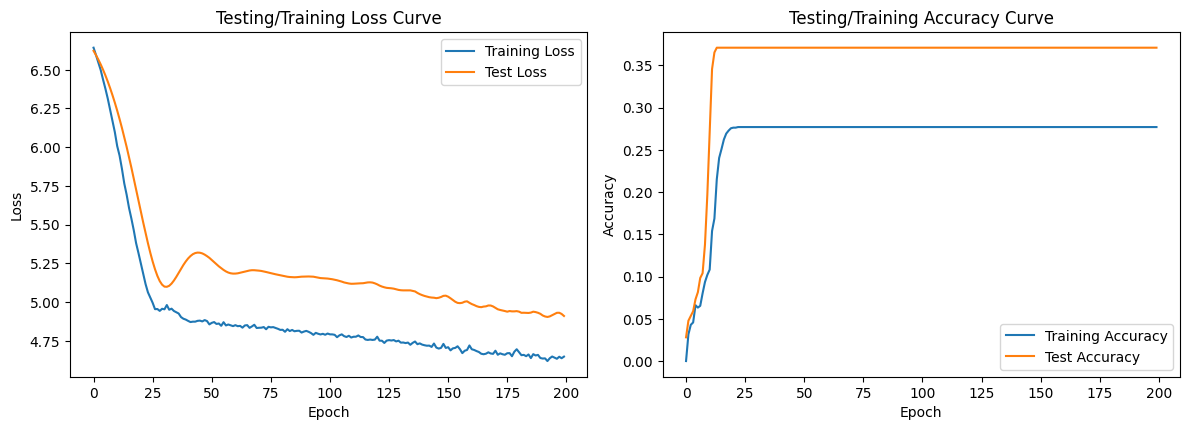

In [135]:
# Plot learning curves
plt.figure(figsize=(12, 8))

# Plot training loss curve
plt.subplot(2, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Testing/Training Loss Curve')
plt.legend()

# Plot training accuracy curve
plt.subplot(2, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Testing/Training Accuracy Curve')
plt.legend()

plt.tight_layout()
plt.show()